# Creating a Neural Network

In this task, we will create a fully connected neural network using low-level mechanisms of TensorFlow.

The architecture of the neural network is depicted in the following diagram. As you can see, it has one input layer, two hidden layers, and an output layer. Sigmoid activation function will be used in the hidden layers, and softmax will be used in the output layer.

Some of the code for creating the network is already written; you need to fill in the gaps at the specified locations.

## Neural Network Architecture

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## About the MNIST Dataset

We will train this neural network on the MNIST dataset. This dataset consists of a large number of handwritten digit images, each of size $28 \times 28$ pixels. Each pixel in these images has a value ranging from 0 to 255.

As before, the dataset will be split into training and testing samples. However, we will perform normalization on all images, scaling pixel values to be in the range from 0 to 1 by dividing the brightness of each pixel by 255.

Additionally, the architecture of the neural network expects input in vector form. In our case, each data point in the dataset is represented as a matrix. So, what should we do? In this task, we will "flatten" the $28 \times 28$ matrix into a vector, resulting in a vector with 784 elements.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

You can find more information about the dataset [here](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install mplcyberpunk
import mplcyberpunk

plt.style.use("cyberpunk")

In [4]:
num_classes = 10  # Total number of classes, in our case, digits from 0 to 9
num_features = 784  # Number of features in the input vector, 28 * 28 = 784

learning_rate = 0.001  # Learning rate for the neural network
training_steps = 3000  # Maximum number of epochs
batch_size = 256  # We will update the network weights on a random subset of batch_size elements, not the entire dataset
display_step = 100  # Display the current loss value and accuracy every 100 iterations

n_hidden_1 = 128  # Number of neurons in the first hidden layer
n_hidden_2 = 256  # Number of neurons in the second hidden layer

In [5]:
from tensorflow.keras.datasets import mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert integer pixels to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten 28x28 pixel matrices into 784-element vectors
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize pixel values
x_train, x_test = x_train / 255., x_test / 255.

# Shuffle training data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


In [6]:
# Create a neural network
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation=None, name=None):
        super().__init__(name=name)
        self.weights = tf.Variable(tf.random.normal([in_features, out_features]))
        self.bias = tf.Variable(tf.zeros([out_features]))
        self.activation = activation

    def __call__(self, x):
        z = tf.matmul(x, self.weights) + self.bias
        if self.activation:
            return self.activation(z)
        return z

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # First layer with 128 neurons and sigmoid activation
        self.layer1 = DenseLayer(num_features, n_hidden_1, activation=tf.nn.sigmoid, name='layer1')
        # Second layer with 256 neurons and sigmoid activation
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, activation=tf.nn.sigmoid, name='layer2')
        # Output layer with softmax activation
        self.out_layer = DenseLayer(n_hidden_2, num_classes, activation=tf.nn.softmax, name='out_layer')

    def __call__(self, x):
        # Pass data through the first two layers and the output layer with softmax activation
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x)
        return tf.nn.softmax(x)

In [7]:
# For the loss function in this case, it's convenient to use cross-entropy
def cross_entropy(y_pred, y_true):
    # Encode the label as a one-hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip predicted values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# For the quality metric, we use accuracy.
def accuracy(y_pred, y_true):
    # Compare predicted values with true labels.
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Compute the average accuracy using casting.
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
# Using Cross-Entropy as the Loss Function
def cross_entropy(y_pred, y_true):
    # Encode the label as a one-hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip predicted values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Using Accuracy as the Quality Metric
def accuracy(y_pred, y_true):
    # Compare predicted values with true labels.
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Compute the average accuracy using casting.
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
# Create an Instance of the Neural Network
neural_net = NN(name="mnist")
# Training Function for the Neural Network
def train(nn, input_x, output_y):
    # We will use stochastic gradient descent to adjust the network weights.
    optimizer = tf.optimizers.SGD(learning_rate)

    # Enable automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Get the list of trainable parameters.
        trainable_variables = nn.trainable_variables

        # Calculate gradients based on them.
        gradients = g.gradient(loss, trainable_variables)

        # Update the parameters.
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss

In [10]:
# Training the Network
loss_history = []  # Store the current loss of the neural network every display_step steps
accuracy_history = []  # Store the current accuracy of the neural network every display_step steps

# In this loop, we will train the neural network using a random subset from the training dataset
# using the `take` method available for the training dataset.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Update the weights of the neural network
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        acc = accuracy(pred, batch_y)
        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")

        # Store the loss and accuracy values
        loss_history.append(loss)
        accuracy_history.append(acc)

print("Training completed!")

Step: 100, Loss: 539.9392700195312, Accuracy: 0.35546875
Step: 200, Loss: 535.93408203125, Accuracy: 0.37109375
Step: 300, Loss: 523.42626953125, Accuracy: 0.4140625
Step: 400, Loss: 514.39794921875, Accuracy: 0.4453125
Step: 500, Loss: 517.71240234375, Accuracy: 0.43359375
Step: 600, Loss: 507.9184875488281, Accuracy: 0.47265625
Step: 700, Loss: 507.8221130371094, Accuracy: 0.4765625
Step: 800, Loss: 503.0301208496094, Accuracy: 0.5
Step: 900, Loss: 499.4388732910156, Accuracy: 0.51171875
Step: 1000, Loss: 503.4260559082031, Accuracy: 0.5
Step: 1100, Loss: 483.68890380859375, Accuracy: 0.578125
Step: 1200, Loss: 489.97479248046875, Accuracy: 0.55078125
Step: 1300, Loss: 482.70379638671875, Accuracy: 0.5703125
Step: 1400, Loss: 473.4639892578125, Accuracy: 0.625
Step: 1500, Loss: 463.7278747558594, Accuracy: 0.65625
Step: 1600, Loss: 466.8761901855469, Accuracy: 0.64453125
Step: 1700, Loss: 465.414794921875, Accuracy: 0.65625
Step: 1800, Loss: 480.502197265625, Accuracy: 0.578125
Step:

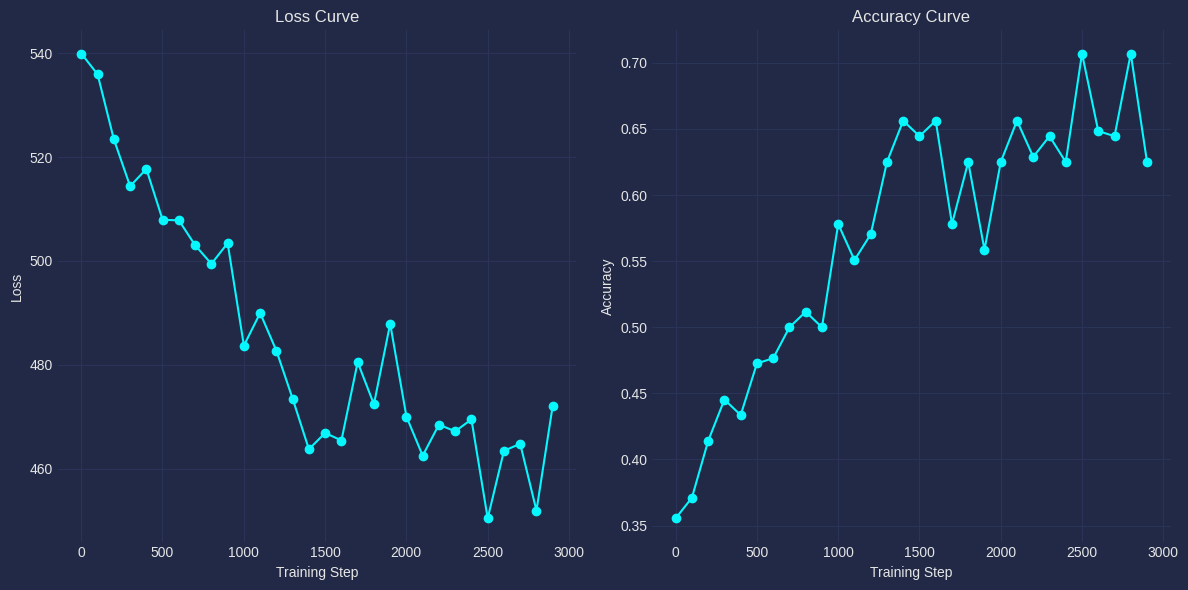

In [11]:
# Plot the graphs showing the change in accuracy and loss over steps
# If everything is done correctly, accuracy should increase while losses decrease
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Loss Curve')
plt.xlabel('Training Step')
plt.ylabel('Loss')

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Accuracy Curve')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [12]:
# Calculate the Accuracy of the Trained Neural Network
# Testing the model on test data
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Accuracy on test data: {test_acc.numpy()}")

Accuracy on test data: 0.642799973487854


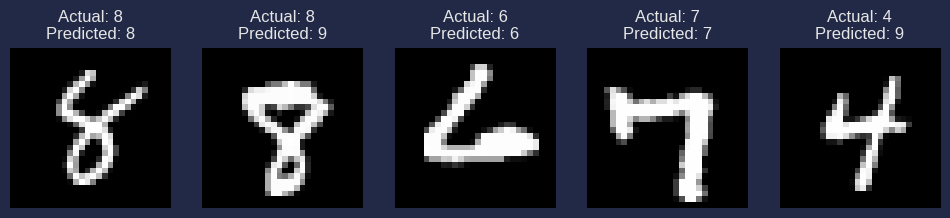

Accuracy on these 5 images: 60.00%


In [13]:
# Test the trained neural network on 10 images. Take 5 random images from the test dataset and feed them into the neural network.
# Display the images and write the neural network's predictions next to them.
# Draw a conclusion about whether your neural network makes mistakes, and if so, how often?
import random

# Select 5 random images from the test dataset
random_indices = random.sample(range(len(x_test)), 5)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Make predictions for the selected images
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Display the images and write the neural network's predictions next to them
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Actual: {test_labels[i]}\nPredicted: {predicted_labels[i]}")
    plt.axis('off')

plt.show()

# Compare predictions with correct labels and calculate accuracy
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Accuracy on these 5 images: {accuracy * 100:.2f}%")
